In [1]:
%load_ext autoreload
%autoreload 2

In [165]:
import numpy as np
import pandas as pd
from numbers import Number
from scipy.optimize import minimize

from api.tools import age_swap_expr, parse_swap_periods
from api.utils import get_expiry_from_code, parse_offset
from api.history_plotter import get_expressions_data
from sklearn.linear_model import LinearRegression
from statsmodels import api as sm

pd.options.plotting.backend = "plotly"

In [3]:
rng = np.random.default_rng(7)

In [4]:
def parse_xl(col_names=None):
    df = pd.read_clipboard(header=None)
    df = df.dropna(how='all').dropna(how='all', axis=1)
    dfis = []
    for j, i in enumerate(range(0, df.shape[1], 2)):
        dfi = df.iloc[:, i:i+2].dropna()
        dfi = dfi.set_index(dfi.columns[0]).squeeze().rename(j)
        dfi = dfi.set_axis(pd.to_datetime(dfi.index.rename('date')))
        dfis.append(dfi)
    data = pd.concat(dfis, axis=1).resample('B').ffill().ffill()
    if col_names:
        data = data.set_axis(col_names, axis=1)
    return data

In [5]:
def var(
    df,
    wgt=None, 
    q=0.05, 
    periods=None, 
    diff=False,
    agg=False,
    scale=1
):
    if periods:
        df = df[-periods:]
    if diff:
        df = df.diff()
    if wgt is None:
        wgt = np.ones(shape=df.shape[1])
    df = df * scale 
    return ((wgt * df).sum(axis=1).quantile(q)) if agg else (wgt * df).quantile(q)

In [6]:
def zscore(df, window=None, df_stats=None, wgt=None):
    
    if wgt is not None:
        df = (df * wgt).sum(axis=1)
    
    if window:
        df = df[-window:]
        if df_stats is not None:
            df_stats = df_stats[-window:]
            if wgt is not None:
                df_stats = (df_stats * wgt).sum(axis=1)
    
    df_stats = df if df_stats is None else df_stats
    mean = df_stats.mean() 
    std = df_stats.std()
    return (df - mean) / std

In [7]:
def fn(
    wgt, 
    d1, 
    d2, 
    z_wgt=None,
    windows=None,
    blend_ratio=0.67
):
    z_wgt = np.array(z_wgt) if z_wgt is not None else np.array([0.5, 0.3, 0.2])
    windows = np.array(windows) if windows else np.array([252*2, 252*5, 252*10])
    
    if len(z_wgt) != len(windows):
        raise ValueError('lenght of windows and z_wgt must match')
    
    d1w = (wgt * d1).sum(axis=1)
    d2w = (wgt * d2).sum(axis=1)
    
    # blended
    z1s = np.array([zscore(d1w, window=win).iloc[-1] for win in windows])
    
    # blended aged
    z2s = np.array([zscore(d1w, window=win, df_stats=d2w).iloc[-1] for win in windows])
    
    return (blend_ratio * (z1s @ z_wgt)) + ((1 - blend_ratio) * z2s @ z_wgt)

### Data

In [66]:
codes = [
    'H4',
    'H5',
    'U3',
    'U4',
    'U5'
]

In [67]:
start_dates = [get_expiry_from_code(code, settle=True) for code in codes]
expiry_tenors = [parse_swap_periods(start_date=start_date, end_date='3m') for start_date in start_dates]

In [152]:
curves = {
    'er': 'eur.3m', 
    'ed': 'usd'
}

In [153]:
future = 'ED'
curve = curves.get(future.lower())
X_expressions = {}
for code, t in zip(codes, expiry_tenors):
    X_expressions[f"{future}{code}"] = f"[s {curve} {t}]"
    
X_expressions = {
    **X_expressions,
    **{f"{key}A": age_swap_expr(val) for key, val in X_expressions.items()},
    'steep': '-EDH4 + EDH5',
    'fly': '-EDU3 + 2*EDU4 - EDU5',
    'steepA': '-EDH4A + EDH5A',
    'flyA': '-EDU3A + 2*EDU4A - EDU5A'
}

In [154]:
X_expressions

{'EDH4': '[s usd 19mx3m]',
 'EDH5': '[s usd 31mx3m]',
 'EDU3': '[s usd 13mx3m]',
 'EDU4': '[s usd 25mx3m]',
 'EDU5': '[s usd 37mx3m]',
 'EDH4A': '[s usd 16mx3m]',
 'EDH5A': '[s usd 28mx3m]',
 'EDU3A': '[s usd 10mx3m]',
 'EDU4A': '[s usd 22mx3m]',
 'EDU5A': '[s usd 34mx3m]',
 'steep': '-EDH4 + EDH5',
 'fly': '-EDU3 + 2*EDU4 - EDU5',
 'steepA': '-EDH4A + EDH5A',
 'flyA': '-EDU3A + 2*EDU4A - EDU5A'}

In [202]:
data = get_expressions_data(X_expressions, history='15y')

In [185]:
pd.Series(X_expressions).to_clipboard(header=False)

In [205]:
d1 = data[['steep', 'fly']]
d2 = data[['steepA', 'flyA']]

In [206]:
df = pd.concat([d1, d2], axis=1)

In [210]:
(d1 * [0.55, 0.45]).sum(axis=1)

2007-08-13    0.169449
2007-08-14    0.180677
2007-08-15    0.173442
2007-08-16    0.234093
2007-08-17    0.195491
                ...   
2022-08-08   -0.443866
2022-08-09   -0.450600
2022-08-10   -0.435494
2022-08-11   -0.466284
2022-08-12   -0.454444
Length: 3915, dtype: float64

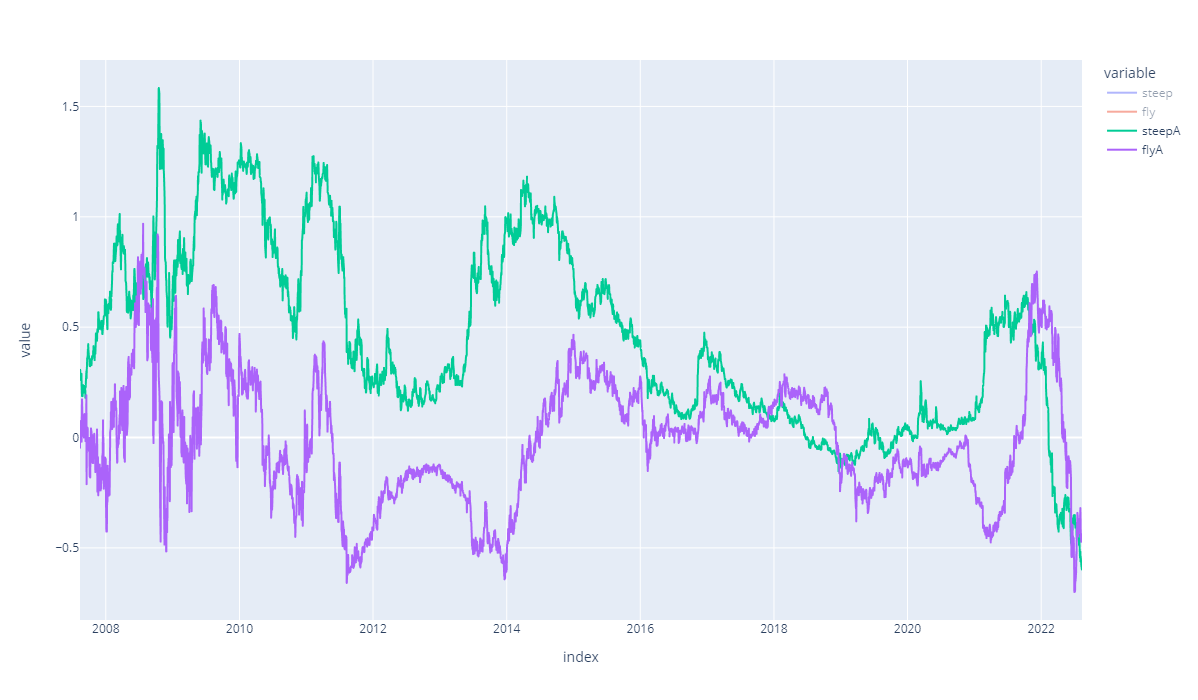

In [207]:
df.plot(height=700)

In [186]:
d1

steep       fly
2012-08-13  0.232088 -0.195089
2012-08-14  0.244048 -0.196951
2012-08-15  0.280418 -0.193196
2012-08-16  0.296530 -0.205629
2012-08-17  0.294044 -0.194916
...              ...       ...
2022-08-08 -0.475325 -0.405417
2022-08-09 -0.492607 -0.399258
2022-08-10 -0.469532 -0.393893
2022-08-11 -0.479239 -0.450451
2022-08-12 -0.460939 -0.435804

[2610 rows x 2 columns]

In [190]:
def opt(d1, d2):
    x0 = rng.normal(size=d1.shape[1])
    res = minimize(
        lambda wgt: -fn(wgt, d1=d1, d2=d2),
        x0=x0,
        # constraints=[
        #     {
        #         'type': 'ineq',
        #         'fun': lambda wgt: 0.3 + var(df=d1, wgt=wgt, periods=522, diff=True, scale=-1)
        #     },
        #     {
        #         'type': 'ineq',
        #         'fun': lambda wgt: 1 + var(df=d1, wgt=wgt, periods=522, agg=True, diff=True, scale=-1)
        #     },
        # ],
        options={
            'maxiter': 10000000,
        }
    )
    return res

In [193]:
def get_df_reg(X, y, diff=False, history=None):
    if diff:
        X = X.diff().dropna()
        y = y.diff().dropna()
    if history:
        X = X.loc[X.index[-1] - parse_offset(history):, :]
        y = y.loc[y.index[-1] - parse_offset(history):]
    df_reg = pd.concat([X, y], axis=1).ffill()
    return df_reg

In [191]:
res = opt(d1, d2)
print(res)
print(res.x / res.x.sum())

      fun: -2.460062123065639
 hess_inv: array([[0.85044092, 0.18159203],
       [0.18159203, 0.78162978]])
      jac: array([-4.47034836e-07,  5.36441803e-07])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([-0.81312749, -0.65021712])
[0.55566371 0.44433629]


In [213]:
X = data['fly'].to_frame()

In [214]:
y = data['steep']

In [200]:
y = (d1 * (-res.x / res.x.sum())).sum(axis=1).rename('y')

In [195]:
def run_regressions(
    X,
    y,
    subsets,  
    history='2y',
    diff=True,
    corr_threshold=None,
    y_col=None,
    sort=True
):
    lms_index = []
    lms_data = []
    lms = {}
    olss = {}
    ols_res = {}
    for subset in subsets:

        df_reg = get_df_reg(
            X[subset], 
            y,
            diff=diff,
            history=history
        )

        y_col = y_col or df_reg.columns[-1]

        if corr_threshold:
            df_reg1 = filter_high_corr(df_reg, threshold=corr_threshold)
        else:
            df_reg1 = df_reg

        key = tuple([*df_reg1.iloc[:, :-1].columns])

        if key not in lms:
            lm = LinearRegression(fit_intercept=True)
            lm.fit(df_reg1.iloc[:, :-1], df_reg1.iloc[:, -1])
            lms[key] = lm

            ols = sm.OLS(df_reg1.iloc[:, -1], sm.add_constant(df_reg1.iloc[:, :-1]))
            res = ols.fit()

            olss[key] = ols
            ols_res[key] = res

            lms_data.append({
                'params': np.round(lm.coef_, 2), 
                'intercept':  np.round(lm.intercept_, 2),
                'r2':  np.round(lm.score(df_reg1.iloc[:, :-1], df_reg1.iloc[:, -1]), 4),
                'contracts': - np.round((lm.coef_ / 2500) * 1e6).astype(int)
            })
    
    summary = pd.DataFrame(lms_data, index=[*lms])
    return {
        'summary': summary.sort_values('r2', ascending=False) if sort else summary,
        'lms': lms,
        'ols': olss,
        'ols_res': ols_res
    }

In [215]:
df_reg = get_df_reg(X, y, True, '6m')

In [216]:
lm = LinearRegression(fit_intercept=True)
lm.fit(df_reg.iloc[:, :-1], df_reg.iloc[:, -1])

ols = sm.OLS(df_reg.iloc[:, -1], sm.add_constant(df_reg.iloc[:, :-1]))
reso = ols.fit()



In [217]:
{
    'params': np.round(lm.coef_, 2), 
    'intercept':  np.round(lm.intercept_, 2),
    'r2':  np.round(lm.score(df_reg.iloc[:, :-1], df_reg.iloc[:, -1]), 4),
    'contracts': - np.round((lm.coef_ / 2500) * 1e6).astype(int)
}

{'params': array([-0.12]),
 'intercept': -0.0,
 'r2': 0.0288,
 'contracts': array([47])}

In [225]:
d1.diff().cov() / X.diff().var().squeeze()

steep       fly
steep  1.056636 -0.242076
fly   -0.242076  1.000000

In [227]:
df_reg.cov() / df_reg.iloc[:, 1].var().squeeze()

fly     steep
fly    2.089732 -0.245188
steep -0.245188  1.000000